In [1]:
# ARMA estimation and forcast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics

import warnings                               
warnings.filterwarnings('ignore')

In [84]:
df = pd.read_csv('./data/sb_history.csv')
df

,Date,Adj Close
0,1993-03-31,1.14
1,1993-04-01,1.16
2,1993-05-03,1.44
3,1993-06-01,1.47
4,1993-07-01,1.42
...,...,...
125,2003-08-01,13.59
126,2003-09-02,13.79
127,2003-10-01,15.13
128,2003-11-03,15.40


In [85]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'])
history = df.set_index('Date')
y = history['Adj Close']
history.head()

,Adj Close
Date,
1993-03-31,1.14
1993-04-01,1.16
1993-05-03,1.44
1993-06-01,1.47
1993-07-01,1.42


In [86]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [87]:
adf_test(y)

Results of Augmented Dickey-Fuller Test:
Test Statistic                   0.942549
p-value                          0.993621
#Lags Used                       8.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


In [88]:
def diff(data, interval):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

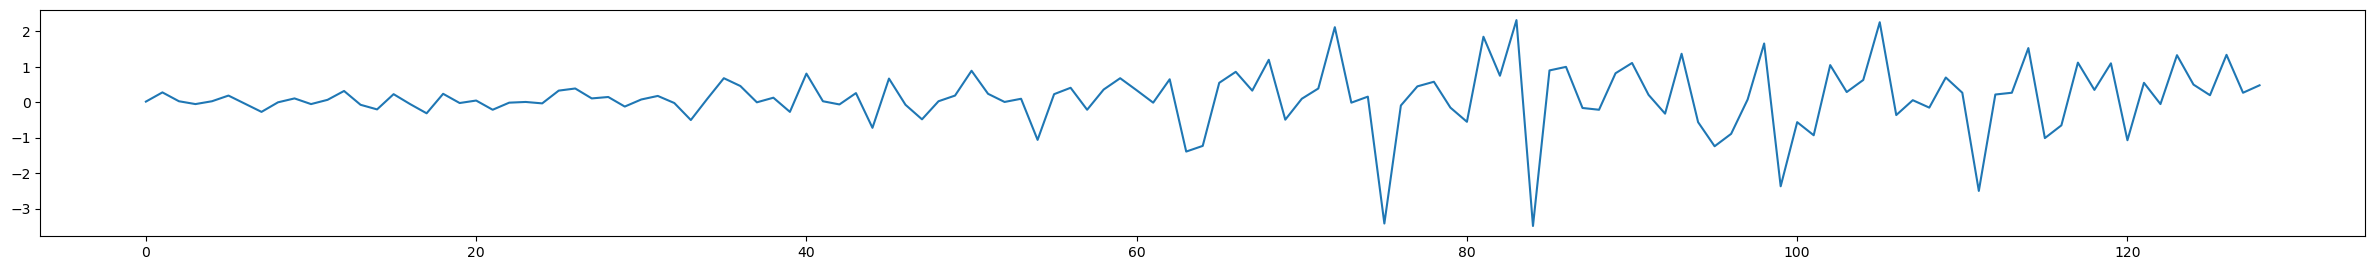

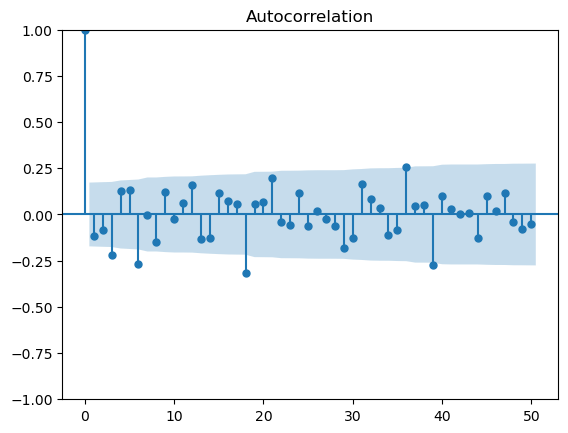

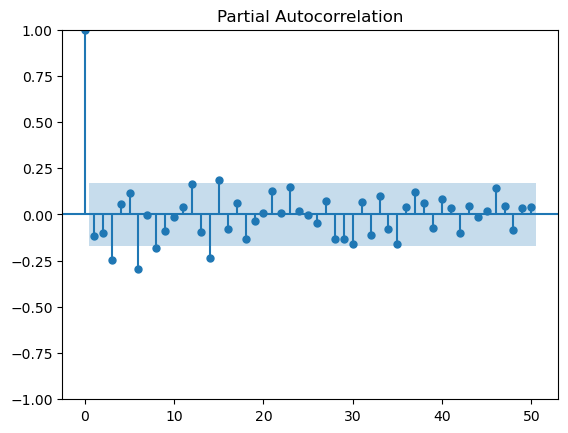

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -4.219031
p-value                          0.000612
#Lags Used                      13.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


In [89]:
D1=diff(y,1)

#visualize the differenced data
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(D1)
plt.show()

plot_acf(D1,lags=50)
plt.show()

plot_pacf(D1,lags=50)
plt.show()

adf_test(D1)

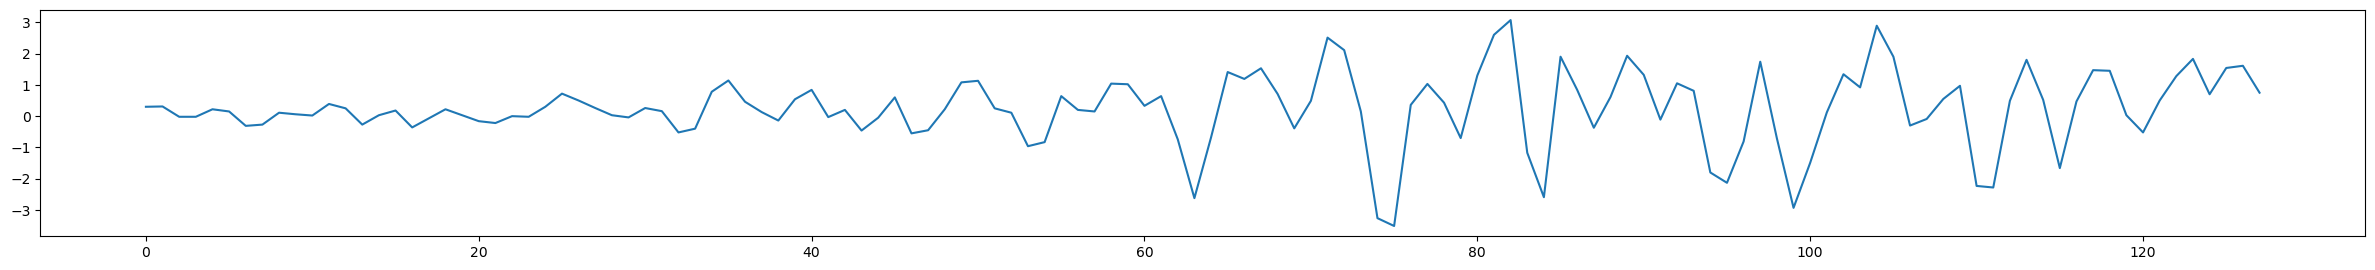

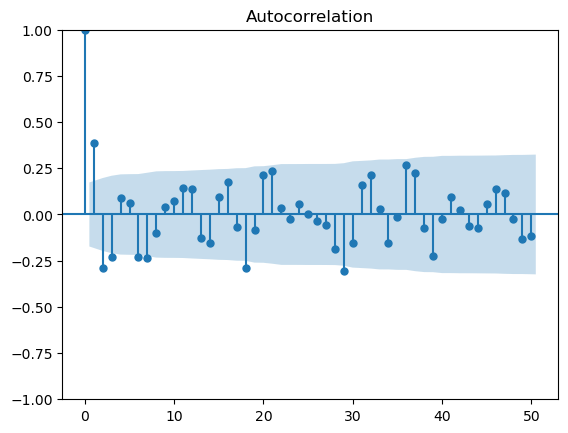

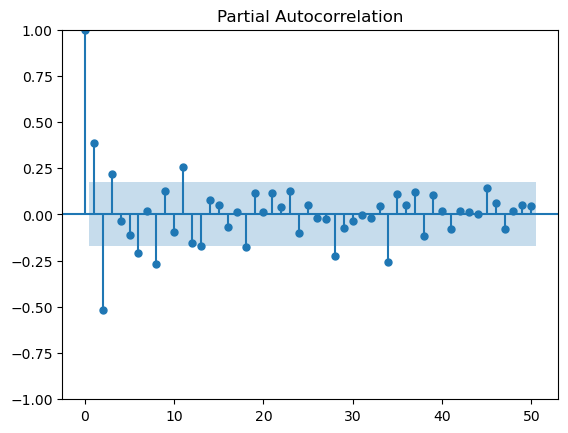

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.981995
p-value                          0.001508
#Lags Used                      12.000000
Number of Observations Used    115.000000
Critical Value (1%)             -3.488535
Critical Value (5%)             -2.887020
Critical Value (10%)            -2.580360
dtype: float64


In [191]:
D2=diff(y,2)

#visualize the differenced data
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(D2)
plt.show()

plot_acf(D2,lags=50)
plt.show()

plot_pacf(D2,lags=50)
plt.show()

adf_test(D2)

In [130]:
def evaluate_models_cv(dataset, p_values, d_values, q_values):
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                validation_size=12
                train_size=94
                rmse=0
                for k in range(0,3):
                    train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+k*validation_size+12]
                    model = ARIMA(train, order=order) #each step: rolling one step forward to update the train se
                    model_fit = model.fit()
                    predictions=model_fit.forecast(len(test))
                    rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                rmse_avg=rmse/3
                result.append((order, rmse_avg))
                if rmse_avg < best_rmse:
                    best_rmse, best_cfg = rmse_avg, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse_avg))
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))

In [131]:
p_values = range(0, 4)
d_values = range(0, 1) #set d=0 for ARMA(p,q) model
q_values = range(0, 4)
evaluate_models_cv(D1, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.009
ARIMA(0, 0, 1) RMSE=1.006
ARIMA(0, 0, 2) RMSE=1.004
ARIMA(0, 0, 3) RMSE=0.965
ARIMA(3, 0, 3) RMSE=0.924
Best ARIMA(3, 0, 3) RMSE=0.924


In [132]:
model = ARIMA(D1,order=(3,0,3)).fit()
pred = model.predict(start=len(D1),end=len(D1)+11)
pred = pd.DataFrame(pred)
pred

,0
0,-0.818165
1,-0.232952
2,-0.424589
3,-0.200098
4,-0.049352
5,-0.203564
6,0.080374
7,-0.063161
8,0.020763
9,0.096283


In [133]:
def inverse_diff(diff_values, original_start, interval):
    original_series = [original_start]
    
    for diff in diff_values:
        value = original_series[-1] + diff
        original_series.append(value)
    
    return original_series[1:]  # Exclude the original_start from the result

last = df['Adj Close'].iloc[-1]
convert_pred = inverse_diff(pred[0], last, 1)
convert_pred = pd.DataFrame(convert_pred)

In [134]:
test = pd.read_csv('./data/sb_test.csv')
test['Date'] = pd.to_datetime(test['Date'])
convert_pred['Date'] = test['Date']
test

,Date,Adj Close
0,2004-01-02,17.53
1,2004-02-02,17.91
2,2004-03-01,18.13
3,2004-04-01,18.64
4,2004-05-03,19.44
5,2004-06-01,20.82
6,2004-07-01,22.50
7,2004-08-02,20.71
8,2004-09-01,21.77
9,2004-10-01,25.32


In [135]:
convert_pred

,0,Date
0,15.061835,2004-01-02
1,14.828882,2004-02-02
2,14.404293,2004-03-01
3,14.204195,2004-04-01
4,14.154843,2004-05-03
5,13.951279,2004-06-01
6,14.031653,2004-07-01
7,13.968492,2004-08-02
8,13.989255,2004-09-01
9,14.085538,2004-10-01


In [136]:
rmse = np.sqrt(skmetrics.mean_squared_error(test['Adj Close'], convert_pred[0].iloc[:12]))
rmse

8.362283948142982

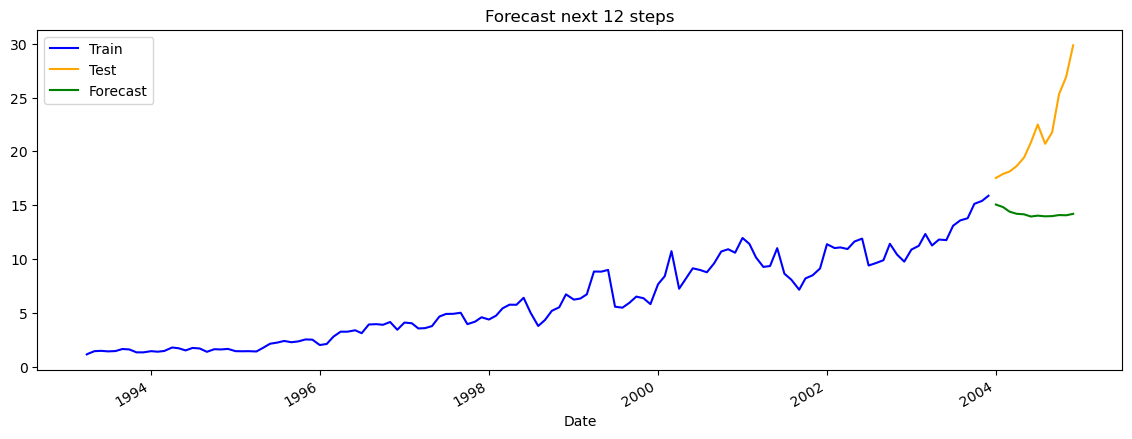

In [137]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
df.plot(kind='line',x='Date' , y='Adj Close', color='blue', label='Train', ax=ax)
test.plot(kind='line',x='Date' , y='Adj Close', color='orange', label='Test', ax=ax)
convert_pred.plot(kind='line', x='Date', y=0, color='green', label='Forecast', ax=ax)
plt.title('Forecast next 12 steps')
plt.show()

In [183]:
def evaluate_models_cv2(dataset, p_values, d_values, q_values, trends):
    best_t, best_rmse, best_cfg = None, float("inf"), None
    for t in trends:
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    validation_size=12
                    train_size=94
                    rmse = 0
                    try:
                        for k in range(0,3):
                            train, test = dataset[0:train_size+k*validation_size],dataset[train_size+k*validation_size:train_size+k*validation_size+12]
                            model = ARIMA(train, order=order, trend=t)
                            model_fit = model.fit()
                            predictions=model_fit.forecast(len(test))
                            rmse = rmse+np.sqrt(skmetrics.mean_squared_error(test, predictions))
                        rmse_avg=rmse/3
                        if rmse_avg < best_rmse:
                            best_rmse, best_cfg, best_t = rmse_avg, order, t
                            print('Trend:%s ARIMA%s RMSE=%.3f' % (t, order,rmse_avg))
                    except:
                        pass
    print('Trend:%s Best ARIMA%s RMSE=%.3f' % (best_t, best_cfg, best_rmse))

In [184]:
trend = ['n','c','t','ct']
p_values = range(0, 4)
d_values = range(0, 3) #set d=0 for ARMA(p,q) model
q_values = range(0, 4)
evaluate_models_cv2(history['Adj Close'], p_values, d_values, q_values, trend)

Trend:n ARIMA(0, 0, 0) RMSE=11.120
Trend:n ARIMA(0, 0, 1) RMSE=10.761
Trend:n ARIMA(0, 0, 2) RMSE=10.551
Trend:n ARIMA(0, 0, 3) RMSE=10.225
Trend:n ARIMA(0, 1, 0) RMSE=2.425
Trend:n ARIMA(0, 1, 2) RMSE=2.403
Trend:n ARIMA(0, 1, 3) RMSE=2.307
Trend:n ARIMA(1, 1, 1) RMSE=2.295
Trend:t ARIMA(0, 0, 0) RMSE=1.602
Trend:t ARIMA(0, 0, 1) RMSE=1.572
Trend:t ARIMA(0, 0, 2) RMSE=1.569
Trend:t ARIMA(0, 0, 3) RMSE=1.566
Trend:t ARIMA(1, 0, 1) RMSE=1.565
Trend:t ARIMA(1, 0, 2) RMSE=1.559
Trend:ct ARIMA(0, 0, 1) RMSE=1.544
Trend:ct ARIMA(1, 0, 2) RMSE=1.542
Trend:ct Best ARIMA(1, 0, 2) RMSE=1.542


In [185]:
model = ARIMA(history,order=(1,0,2), trend='ct').fit()
pred = model.predict(start=len(history),end=len(history)+11)
pred = pd.DataFrame(pred)
pred = pred.reset_index()
pred

,index,predicted_mean
0,130,14.573448
1,131,13.765081
2,132,13.140859
3,133,13.118710
4,134,13.198665
5,135,13.295936
6,136,13.396143
7,137,13.496849
8,138,13.597639
9,139,13.698443


In [188]:
test = pd.read_csv('./data/sb_test.csv')
test['Date'] = pd.to_datetime(test['Date'])
pred['Date'] = test['Date']
pred

,index,predicted_mean,Date
0,130,14.573448,2004-01-02
1,131,13.765081,2004-02-02
2,132,13.140859,2004-03-01
3,133,13.118710,2004-04-01
4,134,13.198665,2004-05-03
5,135,13.295936,2004-06-01
6,136,13.396143,2004-07-01
7,137,13.496849,2004-08-02
8,138,13.597639,2004-09-01
9,139,13.698443,2004-10-01


In [189]:
rmse = np.sqrt(skmetrics.mean_squared_error(test['Adj Close'], pred['predicted_mean']))
rmse

8.855414756951934

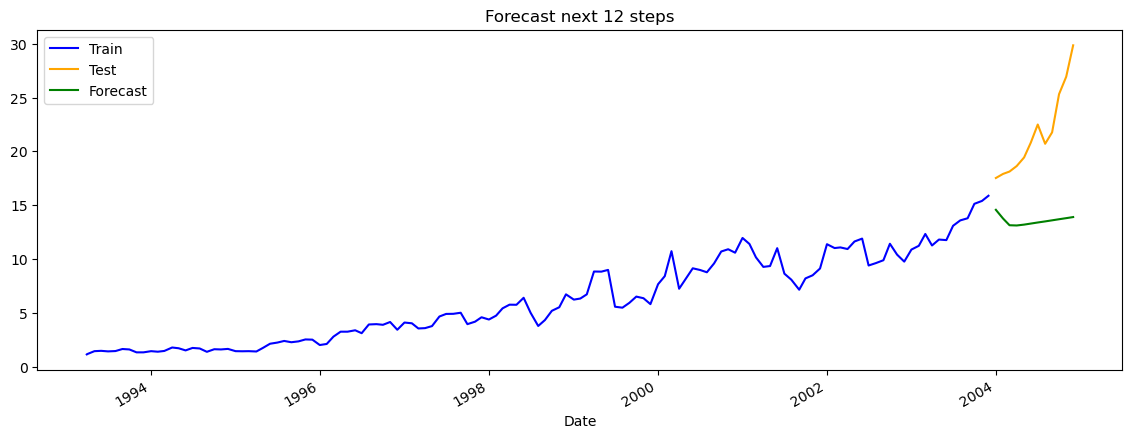

In [190]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
df.plot(kind='line',x='Date' , y='Adj Close', color='blue', label='Train', ax=ax)
test.plot(kind='line',x='Date' , y='Adj Close', color='orange', label='Test', ax=ax)
pred.plot(kind='line', x='Date', y='predicted_mean', color='green', label='Forecast', ax=ax)
plt.title('Forecast next 12 steps')
plt.show()